# data

## extract_world_bank_data

In [63]:
import requests
import pandas as pd

def extract_world_bank_data(indicator: str, output_csv_name: str, metric_name: str) -> None:
    """
    Extracts data from the World Bank API for a given indicator and saves it as a CSV file.

    Parameters:
        indicator (str): The World Bank indicator code to query (e.g., 'SP.DYN.TFRT.IN' for fertility rate).
        output_csv_name (str): The desired name for the output CSV file (e.g., 'd_fertility.csv').
        metric_name (str): The name of the metric to use as the column name in the CSV file (e.g., 'fertility_rate').

    Returns:
        None
    """
    base_url = "http://api.worldbank.org/v2"

    # Get list of all countries (and groupings) from World Bank
    def get_country_metadata():
        country_url = f"{base_url}/country?format=json&per_page=400"
        r = requests.get(country_url)
        total_pages = r.json()[0]['pages']
        country_info = []
        for page in range(1, total_pages + 1):
            r = requests.get(f"{country_url}&page={page}")
            country_info.extend(r.json()[1])
        return {
            c['id']: c['region']['value'] != "Aggregates"
            for c in country_info
        }

    # Build a lookup of country_code -> is_country (True/False)
    country_lookup = get_country_metadata()

    # Get indicator data
    data_url = f"{base_url}/country/all/indicator/{indicator}?format=json&per_page=20000"
    first_page = requests.get(data_url).json()
    total_pages = first_page[0]['pages']

    all_data = []
    for page in range(1, total_pages + 1):
        page_url = f"{data_url}&page={page}"
        r = requests.get(page_url)
        entries = r.json()[1]
        for entry in entries:
            code = entry['countryiso3code']
            if entry['value'] is not None:
                all_data.append({
                    "country_name": entry['country']['value'],
                    "country_code": code,
                    "year": int(entry['date']),
                    metric_name: entry['value'],
                    "is_country": country_lookup.get(code, False)
                })

    # Save to CSV
    df = pd.DataFrame(all_data)
    df.to_csv(output_csv_name, index=False)
    print(f"✅ Saved {output_csv_name} successfully.")

# Example usage:
extract_world_bank_data("SL.TLF.TOTL.FE.ZS", "d_women_labour.csv", "women_perc")

✅ Saved d_women_labour.csv successfully.


## tidy_country_codes

In [64]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('d_women_labour.csv')

# Convert all entries in the 'country_code' column to strings and strip whitespace
df['country_code'] = df['country_code'].astype(str).str.strip()

# Filter for rows where 'country_code' is exactly 'N/A'
na_countries = df[df['country_code'] == 'nan']['country_name'].unique()

# Display the distinct countries with 'N/A' as their country code
print("✅ Countries with 'N/A' as their country_code:")
for country in sorted(na_countries):
    print(country)

✅ Countries with 'N/A' as their country_code:
High income
Low income
Lower middle income
Upper middle income


In [65]:
import pandas as pd

def tidy_country_codes():
    # Load the existing data
    df = pd.read_csv('d_women_labour.csv')

    # ISO A3 codes for countries with N/A codes
    iso_a3_mapping = {
        'Afghanistan': 'AFG', 'Albania': 'ALB', 'American Samoa': 'ASM', 'Andorra': 'AND', 'Anguilla': 'AIA',
        'Antigua and Barbuda': 'ATG', 'Armenia': 'ARM', 'Aruba': 'ABW', 'Azerbaijan': 'AZE', 'Bahamas': 'BHS',
        'Barbados': 'BRB', 'Belize': 'BLZ', 'Benin': 'BEN', 'Bermuda': 'BMU', 'Bhutan': 'BTN', 
        'Bosnia and Herzegovina': 'BIH', 'Botswana': 'BWA', 'Bouvet Island': 'BVT', 
        'British Indian Ocean Territory': 'IOT', 'Brunei Darussalam': 'BRN', 'Cambodia': 'KHM', 
        'Cameroon': 'CMR', 'Cayman Islands': 'CYM', 'Chad': 'TCD', 'Christmas Island': 'CXR', 
        'Cocos (Keeling) Islands': 'CCK', 'Cook Islands': 'COK', 'Curaçao': 'CUW', 'Côte d’Ivoire': 'CIV',
        'Djibouti': 'DJI', 'Dominica': 'DMA', 'Dominican Republic': 'DOM', 'El Salvador': 'SLV', 
        'Eritrea': 'ERI', 'Falkland Islands (Malvinas)': 'FLK', 'Faroe Islands': 'FRO', 
        'Federated States of Micronesia': 'FSM', 'Fiji': 'FJI', 'French Guiana': 'GUF', 
        'French Polynesia': 'PYF', 'French Southern Territories': 'ATF', 'Gambia': 'GMB', 
        'Georgia': 'GEO', 'Gibraltar': 'GIB', 'Greenland': 'GRL', 'Grenada': 'GRD', 
        'Guadeloupe': 'GLP', 'Guam': 'GUM', 'Guyana': 'GUY', 'Haïti': 'HTI', 
        'Heard Island and McDonald Islands': 'HMD', 'Honduras': 'HND', 'Kazakhstan': 'KAZ', 
        'Kiribati': 'KIR', 'Kyrgyzstan': 'KGZ', 'Laos': 'LAO', 'Lebanon': 'LBN', 
        'Liechtenstein': 'LIE', 'Macao': 'MAC', 'Macedonia': 'MKD', 'Madagascar': 'MDG', 
        'Maldives': 'MDV', 'Marshall Islands': 'MHL', 'Martinique': 'MTQ', 'Mauritania': 'MRT', 
        'Mayotte': 'MYT', 'Moldova': 'MDA', 'Monaco': 'MCO', 'Montenegro': 'MNE', 
        'Montserrat': 'MSR', 'Mozambique': 'MOZ', 'Myanmar': 'MMR', 'Namibia': 'NAM', 
        'Nauru': 'NRU', 'Nepal': 'NPL', 'Netherlands Antilles': 'ANT', 'New Caledonia': 'NCL', 
        'Nicaragua': 'NIC', 'Niue': 'NIU', 'Norfolk Island': 'NFK', 'North Korea': 'PRK', 
        'Northern Mariana Islands': 'MNP', 'Palau': 'PLW', 'Palestine': 'PSE', 
        'Papua New Guinea': 'PNG', 'Paraguay': 'PRY', 'Pitcairn': 'PCN', 
        'Republic of South Sudan': 'SSD', 'Reunion': 'REU', 'Saint Helena': 'SHN', 
        'Saint Kitts and Nevis': 'KNA', 'Saint Lucia': 'LCA', 'Saint Martin (Dutch)': 'SXM', 
        'Saint Martin (French)': 'MAF', 'Saint Pierre and Miquelon': 'SPM', 
        'Saint Vincent and the Grenadines': 'VCT', 'Samoa': 'WSM', 'San Marino': 'SMR', 
        'Sao Tome and Principe': 'STP', 'Serbia': 'SRB', 'Seychelles': 'SYC', 
        'Solomon Islands': 'SLB', 'Somalia': 'SOM', 
        'South Georgia and the South Sandwich Islands': 'SGS', 'Sudan': 'SDN', 
        'Suriname': 'SUR', 'Svalbard and Jan Mayen': 'SJM', 'Syrian Arab Republic': 'SYR', 
        'Tajikistan': 'TJK', 'Timor-Leste': 'TLS', 'Tokelau': 'TKL', 'Tonga': 'TON', 
        'Trinidad and Tobago': 'TTO', 'Turkmenistan': 'TKM', 'Turks and Caicos Islands': 'TCA', 
        'Tuvalu': 'TUV', 'United States Minor Outlying Islands': 'UMI', 
        'Uzbekistan': 'UZB', 'Vanuatu': 'VUT', 'Vatican City State': 'VAT', 
        'Virgin Islands (British)': 'VGB', 'Virgin Islands (U.S.)': 'VIR', 
        'Wallis and Futuna': 'WLF', 'Western Sahara': 'ESH', 'Zimbabwe': 'ZWE'
    }

    # Update country codes
    df['country_code'] = df.apply(lambda x: iso_a3_mapping.get(x['country_name'], x['country_code']), axis=1)

    # Save the updated data
    df.to_csv('d_women_labour.csv', index=False)
    print("✅ Country codes updated successfully.")

# Run the function
tidy_country_codes()

✅ Country codes updated successfully.


## tidy_country_names

In [66]:
# import pandas as pd

# # Load the CSV file
# df = pd.read_csv('d_forest.csv')

# # Get unique country names
# unique_countries = df['country_name'].unique()

# # Display all unique country names sorted alphabetically
# print("Unique country names:")
# for country in sorted(unique_countries):
#     print(country)

In [67]:
import pandas as pd

def tidy_country_names(csv_path):
    # Define the country name replacements
    replacements = {
        "Democratic People's Republic of Korea": "North Korea",
        "United Republic of Tanzania": "Tanzania",
        "Netherlands (Kingdom of the)": "Netherlands",
        "Venezuela (Bolivarian Republic of)": "Venezuela",
        "Iran (Islamic Republic of)": "Iran",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
        "Bolivia (Plurinational State of)": "Bolivia",
        "Syrian Arab Republic": "Syria",
        "occupied Palestinian territory, including east Jerusalem": "Palestine",
        "Micronesia (Federated States of)": "Micronesia",
        "Democratic Republic of the Congo": "DR Congo",
        "Republic of Korea": "South Korea",
        "Lao People's Democratic Republic": "Lao",
        "Viet Nam": "Vietnam",
        "Russian Federation": "Russia",
        "United States of America": "United States",
        "Republic of Moldova": "Moldova",
        "Saint Vincent and the Grenadines": "St. Vincent & Grenadines",
        "St. Vincent and the Grenadines": "St. Vincent & Grenadines",
        "West Bank and Gaza": "Palestine",
        "Yemen, Rep.": "Yemen",
        "Venezuela, RB": "Venezuela",
        "Micronesia, Fed. Sts.": "Micronesia",
        "Macao SAR, China": "Macao",
        "Lao PDR": "Lao",
        "Kyrgyz Republic": "Kyrgyzstan",
        "Korea, Rep.": "South Korea",
        "Korea, Dem. People's Rep.": "North Korea",
        "Iran, Islamic Rep.": "Iran",
        "Hong Kong SAR, China": "Hong Kong",
        "Gambia, The": "Gambia",
        "Egypt, Arab Rep.": "Egypt",
        "Congo, Rep.": "Congo",
        "Congo, Dem. Rep.": "DR Congo",
        "Bahamas, The": "The Bahamas",
        "St. Martin (French part)": "St. Martin (French)",
        "Sint Maarten (Dutch part)": "St. Martin (Dutch)",
        "Federated States of Micronesia": "Micronesia",
        "Republic of South Sudan": "South Sudan",
        "Democratic Republic Congo": "DR Congo",
        "Turks and Caicos Islands": "Turks and Caicos",
        "Central African Republic": "Central African Rep.",
        "Northern Mariana Islands": "Northern Mariana"
    }

    # Read CSV
    df = pd.read_csv(csv_path)

    # Replace country names
    df["country_name"] = df["country_name"].replace(replacements)

    # Overwrite CSV
    df.to_csv(csv_path, index=False)

    print(f"✅ Tidied and saved: {csv_path}")

tidy_country_names("d_women_labour.csv")

✅ Tidied and saved: d_women_labour.csv


In [68]:
import pandas as pd

def dedup_csv(input_path="d_women_labour.csv", output_path="d_women_labour.csv"):
    # Load the dataset
    df = pd.read_csv(input_path)
    
    # Remove duplicate rows
    df_deduped = df.drop_duplicates()
    
    # Save the deduplicated dataset
    df_deduped.to_csv(output_path, index=False)
    
    # Report the number of duplicates removed
    duplicates_removed = len(df) - len(df_deduped)
    print(f"✅ Saved deduplicated file to '{output_path}'.")
    print(f"Number of duplicate rows removed: {duplicates_removed}")

# Run the deduplication function
dedup_csv()

✅ Saved deduplicated file to 'd_women_labour.csv'.
Number of duplicate rows removed: 0


## excluded_territories

In [88]:
excluded_territories = {'Channel Islands'}

# # Territories to exclude
# excluded_territories = {
#     'Bouvet Island', 'Christmas Island', 'Cocos (Keeling) Islands', 'Heard Island and McDonald Islands',
#     'Pitcairn', 'South Georgia and the South Sandwich Islands', 'Svalbard and Jan Mayen', 'French Southern Territories',
#     'American Samoa', 'Anguilla', 'Aruba', 'Bermuda', 'British Indian Ocean Territory', 'Cayman Islands',
#     'Cook Islands', 'Curaçao', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana', 'French Polynesia',
#     'Gibraltar', 'Guadeloupe', 'Guam', 'Hong Kong', 'Macao', 'Martinique', 'Mayotte', 'Montserrat',
#     'Netherlands Antilles', 'New Caledonia', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Puerto Rico',
#     'Reunion', 'Saint Barthelemy', 'Saint Helena', 'Saint Martin (Dutch)', 'Saint Martin (French)', 
#     'Saint Pierre and Miquelon', 'Tokelau', 'Turks and Caicos Islands', 'United States Minor Outlying Islands',
#     'Virgin Islands (British)', 'Virgin Islands (U.S.)', 'Wallis and Futuna', 'Vatican City State'
# }

## filter_csv

In [100]:
import pandas as pd
from typing import Union, List, Set

def filter_csv(
    input_path: str = "d_women_labour.csv",
    output_path: str = "d_country_women_labour.csv",
    years: Union[int, List[int], None] = None,
    excluded_territories: Union[Set[str], None] = None,
    only_countries: bool = True
) -> None:
    """
    Filters a CSV file by excluding specified territories, optionally filtering by year(s), and only keeping countries.

    Parameters:
        input_path (str): Path to the input CSV file.
        output_path (str): Path to save the filtered CSV file.
        years (Union[int, List[int], None]): Year(s) to filter by. Can be a single year, list of years, or None.
        excluded_territories (Union[Set[str], None]): A set of territories to exclude. If None, uses default territories.
        only_countries (bool): If True, keeps only rows where 'is_country' is True.

    Returns:
        None
    """
    # Default territories to exclude if not provided
    default_excluded_territories = {
    }

    if excluded_territories is None:
        excluded_territories = default_excluded_territories

    # Load dataset
    df = pd.read_csv(input_path)

    # Filter out excluded territories
    df = df[~df['country_name'].isin(excluded_territories)]

    # Filter to only countries if specified
    if only_countries:
        df = df[df['is_country'] == True]

    # Optional: filter by year(s)
    if years is not None:
        if isinstance(years, int):
            years = [years]
        df = df[df["year"].isin(years)]

    # Save filtered dataset
    df.to_csv(output_path, index=False)
    print(f"✅ Saved {output_path} successfully.")

# Example usage
filter_csv(years=2023, only_countries=True, excluded_territories=excluded_territories)

✅ Saved d_country_women_labour.csv successfully.


## order_csv

In [101]:
import pandas as pd

def order_csv(csv_path, column_name, direction="asc"):
    # Read the CSV
    df = pd.read_csv(csv_path)

    # Check sort direction
    ascending = True if direction.lower() == "asc" else False

    # Sort the DataFrame
    df_sorted = df.sort_values(by=column_name, ascending=ascending)

    # Save back to the same file
    df_sorted.to_csv(csv_path, index=False)

    print(f"✅ Sorted by '{column_name}' ({direction}) and saved: {csv_path}")

order_csv('d_country_women_labour.csv', 'women_perc', "asc")

✅ Sorted by 'women_perc' (asc) and saved: d_country_women_labour.csv


## load_world_geojson

In [102]:
import geopandas as gpd
import requests

def load_world_geojson(source='local'):
    """
    Load world map from a local simplified GeoJSON or a simplified online version.

    Parameters:
        source (str): 'local' or 'web'

    Returns:
        GeoDataFrame or dict: GeoDataFrame if local, dict if web
    """
    if source == 'local':
        local_geojson_path = "../ne_10m_admin_0_countries_lakes/world_simplified.geojson"
        try:
            print(f"📁 Loading local simplified GeoJSON from: {local_geojson_path}")
            return gpd.read_file(local_geojson_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"❌ GeoJSON file not found at: {local_geojson_path}")

    elif source == 'web':
        print("🌍 Loading simplified GeoJSON from Johan's GitHub...")
        geojson_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
        response = requests.get(geojson_url)
        response.raise_for_status()
        return response.json()

    else:
        raise ValueError("Invalid source. Use 'local' or 'web'.")

world_geojson = load_world_geojson('web')

🌍 Loading simplified GeoJSON from Johan's GitHub...


# visualise

## small_country_coords

In [103]:
small_countries_coords = {
    'ABW': (12.5, -69.97),     # Aruba
    'AND': (42.5, 1.5),        # Andorra
    'ASM': (-14.3, -170.7),    # American Samoa
    'ATG': (17.1, -61.8),      # Antigua and Barbuda
    'BHR': (26.0, 50.5),       # Bahrain
    'BHS': (25.03, -77.4),     # The Bahamas
    'BMU': (32.3, -64.8),      # Bermuda
    'BRB': (13.1, -59.6),      # Barbados
    #'CHI': (49.5, -2.5),       # Channel Islands (approx. between Jersey and Guernsey)
    'COK': (-21.2, -159.8),    # Cook Islands
    'COM': (-11.6, 43.3),      # Comoros
    'CPV': (15.1, -23.6),      # Cape Verde
    'CUW': (12.2, -69.0),      # Curaçao
    'CYP': (35.1, 33.4),       # Cyprus
    'DJI': (11.8, 42.6),       # Djibouti
    'DMA': (15.4, -61.4),      # Dominica
    'FJI': (-17.7134, 178.065), # Fiji (Suva approx.)
    'FRO': (62.0, -6.79),      # Faroe Islands
    'FSM': (6.9, 158.2),       # Micronesia (Federated States of)
    'GIB': (36.1, -5.35),      # Gibraltar
    'GMB': (13.5, -15.5),      # Gambia
    'GNQ': (1.6, 10.5),        # Equatorial Guinea
    'GNB': (11.8, -15.2),      # Guinea-Bissau
    'GUM': (13.44, 144.79),    # Guam
    'HKG': (22.3, 114.2),      # Hong Kong
    'IMN': (54.2, -4.55),      # Isle of Man
    'JAM': (18.1, -77.3),      # Jamaica
    'KIR': (1.87, 173.0),      # Kiribati
    'KNA': (17.3, -62.7),      # Saint Kitts and Nevis
    'KWT': (29.3759, 47.9774), # Kuwait (Kuwait City approx.)
    'LCA': (13.9, -60.98),     # Saint Lucia
    'LUX': (49.8, 6.1),        # Luxembourg
    'MAC': (22.2, 113.6),      # Macao
    'MAF': (18.07, -63.05),    # St Martin (French)
    'MDV': (3.2, 73.2),        # Maldives
    'MLT': (35.9, 14.5),       # Malta
    'MHL': (7.1, 171.0),       # Marshall Islands
    'MCO': (43.7333, 7.4200),  # Monaco
    'MUS': (-20.2, 57.5),      # Mauritius
    'NCL': (-22.27, 166.44),   # New Caledonia
    'NIU': (-19.05, -169.86),  # Niue
    'NRU': (-0.52, 166.93),    # Nauru
    'OMN': (21.5, 55.9),       # Oman
    'PLW': (7.5, 134.5),       # Palau
    'PRI': (18.2, -66.5),      # Puerto Rico
    'PYF': (-17.6797, -149.4068),  # French Polynesia (Tahiti approx.)
    'QAT': (25.3, 51.5),       # Qatar
    'SGP': (1.35, 103.8),      # Singapore
    'SLB': (-9.6, 160.2),      # Solomon Islands
    'SMR': (43.9333, 12.45),   # San Marino
    'STP': (0.2, 6.6),         # Sao Tome and Principe
    'SYC': (-4.6, 55.5),       # Seychelles
    'SXM': (18.04, -63.07),    # St Martin (Dutch)
    'TKL': (-9.2, -171.8),     # Tokelau
    'TON': (-21.2, -175.2),    # Tonga
    'TCA': (21.8, -72.1),      # Turks and Caicos Islands
    'TUV': (-7.1, 179.2),      # Tuvalu
    'VCT': (13.25, -61.2),     # Saint Vincent and the Grenadines
    'VGB': (18.4, -64.6),      # British Virgin Islands
    'VIR': (18.34, -64.89),    # US Virgin Islands
    'VUT': (-16.0, 167.0),     # Vanuatu
    'WSM': (-13.8, -172.1),    # Samoa
}

## color_schemes

In [104]:
# Define color schemes as a dictionary
color_schemes = {
    "blue": {
        "color_5": "143,217,251",
        "color_25": "96,179,244",
        "color_50": "48,140,238",
        "color_75": "24,72,196",
        "color_95": "17,17,132"
    },
    "red": {
        "color_5": "255,255,153",
        "color_25": "255,217,128",
        "color_50": "255,165,0",
        "color_75": "255,82,0",
        "color_95": "204,0,0"
    },
    "green": {
        "color_5": "204,255,204",
        "color_25": "153,230,153",
        "color_50": "102,204,102",
        "color_75": "0,128,0",
        "color_95": "0,100,0"
    },
    "forest": {
        "color_5": "139,69,19",
        "color_25": "195,176,145",
        "color_50": "150,200,150",
        "color_75": "0,150,0",
        "color_95": "0,100,0"
    },
        "purple": {
            "color_5": "240,210,240",
            "color_25": "215,140,215",
            "color_50": "170,75,170",
            "color_75": "130,20,130",
            "color_95": "55,0,95"
        }

}

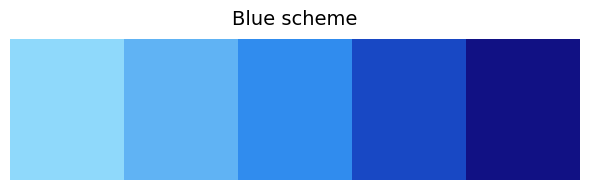

In [121]:
def show_color_schemes(schemes=None):
    import matplotlib.pyplot as plt

    if schemes is None:
        schemes = color_schemes.keys()
    elif isinstance(schemes, str):
        schemes = [schemes]

    selected_schemes = {k: v for k, v in color_schemes.items() if k in schemes}

    fig, axes = plt.subplots(nrows=len(selected_schemes), figsize=(6, 2 * len(selected_schemes)))
    if len(selected_schemes) == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, (name, scheme) in zip(axes, selected_schemes.items()):
        colors = [tuple(map(int, c.split(','))) for c in scheme.values()]
        colors = [[(r / 255, g / 255, b / 255) for r, g, b in colors]]

        ax.imshow(colors, aspect='auto')
        ax.set_title(f'{name.capitalize()} scheme', fontsize=14, pad=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_color_schemes(['blue'])

## map_frames

In [106]:
import pandas as pd
import plotly.graph_objects as go
import os
import shutil

def map_frames(
    csv_filename,
    world_geojson,
    small_countries_coords,
    color_scheme,
    metric='obesity_rate',
    plot_height=1080,
    plot_width=1920,
    marker_size=10,
    marker_border=3.5,
    parent_folder='2023-03_obesity',
    output_folder='frames_world',
    clear=True
):
    try:
        df = pd.read_csv(csv_filename)
    except FileNotFoundError:
        raise FileNotFoundError(f"CSV file '{csv_filename}' not found. Please check the path.")

    if metric not in df.columns:
        raise ValueError(f"Metric '{metric}' not found in the provided CSV file. Available columns: {list(df.columns)}")

    latest_year = df['year'].max()
    df = df[df['year'] == latest_year].reset_index(drop=True)
    
    try:
        color_5 = color_scheme['color_5']
        color_25 = color_scheme['color_25']
        color_50 = color_scheme['color_50']
        color_75 = color_scheme['color_75']
        color_95 = color_scheme['color_95']
    except KeyError:
        raise ValueError("The color scheme must contain 'color_5', 'color_25', 'color_50', 'color_75', and 'color_95' keys.")

    color_5_value = df[metric].quantile(0.05)
    color_25_value = df[metric].quantile(0.25)
    color_50_value = df[metric].quantile(0.50)
    color_75_value = df[metric].quantile(0.75)
    color_95_value = df[metric].quantile(0.95)

    color_boundaries = {
        "color_5_value": color_5_value,
        "color_25_value": color_25_value,
        "color_50_value": color_50_value,
        "color_75_value": color_75_value,
        "color_95_value": color_95_value
    }

    all_countries = pd.DataFrame({
        'country_code': [
            feature.get('id') or feature['properties'].get('iso_a3')
            for feature in world_geojson['features']
        ]
    })

    small_countries = pd.DataFrame([
        {'country_code': code, 'lat': lat, 'lon': lon}
        for code, (lat, lon) in small_countries_coords.items()
    ])
    
    output_path = f"/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/{parent_folder}/{output_folder}"
    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)
    
    colorscale = [
        [0.0, f'rgb({color_5})'],
        [0.25, f'rgb({color_25})'],
        [0.5, f'rgb({color_50})'],
        [0.75, f'rgb({color_75})'],
        [1.0, f'rgb({color_95})']
    ]

    for i in range(1, len(df) + 1):
        df_partial = df.iloc[:i]

        df_partial = df_partial.copy()
        df_partial.loc[:, 'row_index'] = df_partial.index

        df_merged = all_countries.merge(
            df_partial[['country_code', 'country_name', metric, 'row_index']],
            on='country_code', how='left'
        ).sort_values(by='row_index', ascending=True)

        small_data = small_countries.merge(
            df_partial[['country_code', metric, 'row_index']],
            on='country_code',
            how='left'
        ).dropna(subset=[metric]).sort_values(by='row_index', ascending=True)

        fig = go.Figure()

        fig.add_trace(go.Choropleth(
            geojson=world_geojson,
            locations=df_merged['country_code'],
            z=df_merged[metric],
            locationmode='ISO-3',
            colorscale=colorscale,
            zmin=color_5_value,
            zmax=color_95_value,
            colorbar_title=metric.replace("_", " ").capitalize(),
            text=df_merged['country_name'],
            hoverinfo='location+z+text',
            marker_line_color='white',
            marker_line_width=1.5,
        ))

        fig.add_trace(go.Scattergeo(
            lon=small_data['lon'],
            lat=small_data['lat'],
            mode='markers',
            marker=dict(
                size=marker_size,
                color=small_data[metric],
                colorscale=colorscale,
                cmin=color_5_value,
                cmax=color_95_value,
                line=dict(width=marker_border, color='white')
            ),
            hoverinfo='skip',
            showlegend=False
        ))

        fig.update_geos(
            showcountries=True,
            countrycolor="white",
            showframe=False,
            showcoastlines=False,
            showlakes=False,
            bgcolor='rgba(0,0,0,0)',
            lataxis_range=[-60, 90],
            projection_rotation={"lon": 40}
        )

        fig.update_layout(
            margin={"r": 0, "t": 0, "l": 0, "b": 0},
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            height=plot_height,
            width=plot_width
        )

        filepath = f"{output_path}/{i:04d}.png"
        fig.write_image(filepath, scale=1)

        current_country = df_partial.iloc[-1]['country_name']
        print(f"✅ Saved {filepath} – added: {current_country}")
    
    return color_boundaries

In [107]:
color_boundaries = map_frames(
    csv_filename="d_country_women_labour.csv",
    world_geojson=world_geojson,
    small_countries_coords=small_countries_coords,
    color_scheme=color_schemes["purple"],
    metric="women_perc",
    plot_height=1080,
    plot_width=1920,
    marker_size=23,
    marker_border=2,
    parent_folder="2023-03_women_labour",
    output_folder="frames_map",
    clear=True
)


✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_map/0001.png – added: Afghanistan
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_map/0002.png – added: Yemen
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_map/0003.png – added: Iraq
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_map/0004.png – added: Oman
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_map/0005.png – added: Iran
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_map/0006.png – added: Algeria
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_map/0007.png – added: Jordan
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_map/0008.png – added: Egypt
✅ Saved /U

## text_frames

In [108]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
import shutil

def interpolate_color(val, color_boundaries, rgb_colors):
    boundaries = [
        color_boundaries["color_5_value"],
        color_boundaries["color_25_value"],
        color_boundaries["color_50_value"],
        color_boundaries["color_75_value"],
        color_boundaries["color_95_value"]
    ]
    
    if val <= boundaries[0]:
        return rgb_colors[0]
    elif val >= boundaries[-1]:
        return rgb_colors[-1]

    for i in range(len(boundaries) - 1):
        if boundaries[i] <= val <= boundaries[i + 1]:
            lower_bound = boundaries[i]
            upper_bound = boundaries[i + 1]
            ratio = (val - lower_bound) / (upper_bound - lower_bound)
            
            lower_color = rgb_colors[i]
            upper_color = rgb_colors[i + 1]
            
            interpolated_color = tuple([
                int(lower_color[j] + ratio * (upper_color[j] - lower_color[j]))
                for j in range(3)
            ])
            
            return interpolated_color

def save_text_component(text, text_color, outline_color, font, image_width, image_height, x, y, filepath):
    img = Image.new('RGBA', (image_width, image_height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(img)

    offset = 2
    for dx in [-offset, 0, offset]:
        for dy in [-offset, 0, offset]:
            if dx == 0 and dy == 0:
                continue
            draw.text((x + dx, y + dy), text, font=font, fill=outline_color)
    
    draw.text((x, y), text, font=font, fill=text_color)
    img.save(filepath)
    print(f"💬 Saved {filepath}")

def text_frames(
    csv_filename,
    color_scheme,
    parent_folder='2023-03_forest',
    output_folder='frames_text',
    output_folder_suffix='',
    metric='forest_area',
    font_type='ExtraBold',
    font_size=100,
    image_width=1920,
    image_height=1080,
    append_percent=False,
    clear=True
):
    color_5 = color_scheme['color_5']
    color_25 = color_scheme['color_25']
    color_50 = color_scheme['color_50']
    color_75 = color_scheme['color_75']
    color_95 = color_scheme['color_95']

    rgb_colors = [
        tuple(map(int, color_5.split(','))),
        tuple(map(int, color_25.split(','))),
        tuple(map(int, color_50.split(','))),
        tuple(map(int, color_75.split(','))),
        tuple(map(int, color_95.split(',')))
    ]

    full_output_folder = os.path.join(parent_folder, output_folder + output_folder_suffix)
    base_output_path = os.path.join(
        "/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics",
        full_output_folder
    )
    
    if clear and os.path.exists(base_output_path):
        shutil.rmtree(base_output_path)
    os.makedirs(base_output_path, exist_ok=True)

    text_types = ['title', 'value', 'rank', 'country']
    text_paths = {text_type: os.path.join(base_output_path, text_type) for text_type in text_types}
    for path in text_paths.values():
        os.makedirs(path, exist_ok=True)

    df = pd.read_csv(csv_filename)
    latest_year = df['year'].max()
    df = df[df['year'] == latest_year].reset_index(drop=True)

    color_boundaries = {
        "color_5_value": df[metric].quantile(0.05),
        "color_25_value": df[metric].quantile(0.25),
        "color_50_value": df[metric].quantile(0.50),
        "color_75_value": df[metric].quantile(0.75),
        "color_95_value": df[metric].quantile(0.95)
    }

    df['rank'] = df[metric].rank(method='min', ascending=False).astype(int)

    font_path = os.path.join("..", "..", "Montserrat", f"Montserrat-{font_type}.ttf")
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Montserrat font '{font_type}' not found. Using default font.")
        font = ImageFont.load_default()

    for i in range(1, len(df) + 1):
        row = df.iloc[i - 1]
        country = row['country_name']
        rate_numeric = row[metric]
        rank = row['rank']
        
        if append_percent:
            rate_formatted = f"{row[metric]:,.1f}%"
        else:
            rate_formatted = f"{row[metric]:,.1f}"

        text_color = interpolate_color(
            rate_numeric, color_boundaries, rgb_colors
        )

        outline_color = (255, 255, 255)

        texts = {
            'title': "FEMALE",
            'value': rate_formatted,
            'rank': f"#{rank}",
            'country': country.upper()
        }

        x = 100
        y_positions = {
            'title': 100,
            'value': 250,
            'rank': 400,
            'country': 550
        }

        for text_type, text in texts.items():
            y = y_positions[text_type]
            filepath = os.path.join(text_paths[text_type], f"{i:04d}.png")
            save_text_component(text, text_color, outline_color, font, image_width, image_height, x, y, filepath)

In [109]:
text_frames(
    csv_filename="d_country_women_labour.csv",
    color_scheme=color_schemes["purple"],
    parent_folder="2023-03_women_labour",
    output_folder="frames_text",
    metric="women_perc",
    font_type="ExtraBold",
    font_size=100,
    image_width=1920,
    image_height=1080,
    append_percent=True,
    clear=True
)

💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_text/title/0001.png
💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_text/value/0001.png
💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_text/rank/0001.png
💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_text/country/0001.png
💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_text/title/0002.png
💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_text/value/0002.png
💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_text/rank/0002.png
💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_text/country/0002.png
💬 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_wom

## flag_frames

In [110]:
import pandas as pd
import os
import shutil
import requests
from PIL import Image
from io import BytesIO
from pycountry import countries

def flag_frames(
    csv_filename,
    parent_folder='2023-03_obesity',
    output_folder='frames_flag',
    image_width=1920,
    image_height=1080,
    flag_height=540,  # Desired height for all flags (half of 1080 for consistency)
    clear=True
):
    output_path = os.path.join(
        "/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics",
        parent_folder,
        output_folder
    )

    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)

    # Load data and preserve original order
    df = pd.read_csv(csv_filename)
    latest_year = df['year'].max()
    df = df[df['year'] == latest_year].reset_index(drop=True)

    # Create ISO-3 to ISO-2 mapping
    iso_map = {c.alpha_3: c.alpha_2.lower() for c in countries if hasattr(c, 'alpha_3')}

    for i in range(len(df)):
        row = df.iloc[i]
        code3 = row['country_code']
        country = row['country_name']
        code2 = iso_map.get(code3)

        if not code2:
            print(f"⚠️ No ISO-2 code for {country} ({code3})")
            continue

        url = f"https://flagcdn.com/w320/{code2}.png"
        try:
            response = requests.get(url)
            response.raise_for_status()
            flag = Image.open(BytesIO(response.content)).convert("RGBA")
        except Exception as e:
            print(f"❌ Failed to load flag for {country} ({code3}): {e}")
            continue

        # Resize the flag to the desired height, maintaining aspect ratio
        flag_aspect = flag.width / flag.height
        target_width = int(flag_height * flag_aspect)
        flag = flag.resize((target_width, flag_height), Image.LANCZOS)

        # Create a blank transparent image
        img = Image.new("RGBA", (image_width, image_height), (0, 0, 0, 0))

        # Calculate position for right alignment
        x = image_width - flag.width  # Right-aligned
        y = (image_height - flag.height) // 2  # Vertically centered

        # Paste the flag onto the transparent background
        img.paste(flag, (x, y), flag)

        filepath = os.path.join(output_path, f"{i+1:04d}.png")
        img.save(filepath)
        print(f"🇺🇳 Saved {filepath} – {country}")

In [119]:
flag_frames(
    csv_filename='d_country_women_labour.csv',
    parent_folder='2023-03_women_labour',
    output_folder='frames_flag',
    image_width=1920,
    image_height=1080,
    flag_height=540,
    clear=True
)

🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_flag/0001.png – Afghanistan
🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_flag/0002.png – Yemen
🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_flag/0003.png – Iraq
🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_flag/0004.png – Oman
🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_flag/0005.png – Iran
🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_flag/0006.png – Algeria
🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_flag/0007.png – Jordan
🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_flag/0008.png – Egypt
🇺🇳 Saved /Users/arya/Documents/Adobe/Premiere Pro/

## history_frames

In [112]:
def history_map_frames(
    csv_filename,
    world_geojson,
    small_countries_coords,
    color_scheme,
    excluded_territories,
    metric='forest_perc',
    plot_height=1080,
    plot_width=1920,
    parent_folder='2023-03_forest',
    output_folder='frames_history',
    clear=True,
    marker_size=23,
    marker_border=2
):
    import pandas as pd
    import plotly.graph_objects as go
    import os
    import shutil

    # Load data
    df = pd.read_csv(csv_filename)

    # Retrieve all available years, including 2024
    years = sorted(df["year"].dropna().unique(), reverse=True)

    # Log available years
    print(f"📅 Available years: {years}")

    # Prepare the output directory
    output_path = f"/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/{parent_folder}/{output_folder}"
    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)

    geojson = world_geojson

    all_countries = pd.DataFrame({
        'country_code': [
            feature.get('id') or feature['properties'].get('iso_a3')
            for feature in geojson['features']
        ]
    })

    small_countries = pd.DataFrame([
        {'country_code': code, 'lat': lat, 'lon': lon}
        for code, (lat, lon) in small_countries_coords.items()
    ])

    # Process each year individually
    for index, year in enumerate(years, start=1):
        # Filter data for the current year
        df_year = df[df['year'] == year].reset_index(drop=True)

        if df_year.empty:
            print(f"🚫 No data available for year {year}. Skipping...")
            continue

        # Exclude territories
        if excluded_territories:
            df_year = df_year[~df_year['country_name'].isin(excluded_territories)]

        # Calculate color boundaries
        color_boundaries = {
            "color_5_value": df_year[metric].quantile(0.05),
            "color_25_value": df_year[metric].quantile(0.25),
            "color_50_value": df_year[metric].quantile(0.50),
            "color_75_value": df_year[metric].quantile(0.75),
            "color_95_value": df_year[metric].quantile(0.95)
        }

        # Extract color scheme
        colorscale = [
            [0.0, f'rgb({color_scheme["color_5"]})'],
            [0.25, f'rgb({color_scheme["color_25"]})'],
            [0.50, f'rgb({color_scheme["color_50"]})'],
            [0.75, f'rgb({color_scheme["color_75"]})'],
            [1.0, f'rgb({color_scheme["color_95"]})']
        ]

        df_merged = all_countries.merge(
            df_year[["country_code", "country_name", metric]],
            on="country_code", how="left"
        )

        small_data = small_countries.merge(
            df_year[["country_code", metric]],
            on="country_code",
            how="left"
        )
        small_data = small_data[small_data[metric].notna()]

        fig = go.Figure()

        # Choropleth
        fig.add_trace(go.Choropleth(
            geojson=geojson,
            locations=df_merged['country_code'],
            z=df_merged[metric],
            locationmode='ISO-3',
            colorscale=colorscale,
            zmin=color_boundaries["color_5_value"],
            zmax=color_boundaries["color_95_value"],
            colorbar_title=metric.replace("_", " ").capitalize(),
            text=df_merged['country_name'],
            hoverinfo='location+z+text',
            marker_line_color='white',
            marker_line_width=1.5,
        ))

        # Small country markers
        fig.add_trace(go.Scattergeo(
            lon=small_data['lon'],
            lat=small_data['lat'],
            mode='markers',
            marker=dict(
                size=marker_size,
                color=small_data[metric],
                colorscale=colorscale,
                cmin=color_boundaries["color_5_value"],
                cmax=color_boundaries["color_95_value"],
                colorbar=None,
                line=dict(width=marker_border, color='white'),
                opacity=1.0
            ),
            hoverinfo='skip',
            showlegend=False
        ))

        # Global map layout
        fig.update_geos(
            showcountries=True,
            countrycolor="white",
            showframe=False,
            showcoastlines=False,
            showlakes=False,
            bgcolor='rgba(0,0,0,0)',
            lataxis_range=[-60, 90],
            projection_rotation={"lon": 40}
        )

        fig.update_layout(
            margin={"r": 0, "t": 0, "l": 0, "b": 0},
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            height=plot_height,
            width=plot_width,
            coloraxis_colorbar=dict(
                len=0.5,
                yanchor='middle',
                y=0.5
            )
        )

        filepath = f"{output_path}/{index:04d}.png"
        fig.write_image(filepath, scale=1)
        print(f"✅ Saved {filepath} for year {year}")


In [113]:
history_map_frames(
    csv_filename="d_women_labour.csv",
    world_geojson=world_geojson,
    small_countries_coords=small_countries_coords,
    color_scheme=color_schemes["purple"],  # Use the specific color scheme
    excluded_territories=excluded_territories,
    metric="women_perc",
    plot_height=1080,
    plot_width=1920,
    parent_folder="2023-03_women_labour",
    output_folder="frames_history_map",
    clear=True,
    marker_size=23,
    marker_border=2  # New parameter to control marker border thickness
)

📅 Available years: [np.int64(2023), np.int64(2022), np.int64(2021), np.int64(2020), np.int64(2019), np.int64(2018), np.int64(2017), np.int64(2016), np.int64(2015), np.int64(2014), np.int64(2013), np.int64(2012), np.int64(2011), np.int64(2010), np.int64(2009), np.int64(2008), np.int64(2007), np.int64(2006), np.int64(2005), np.int64(2004), np.int64(2003), np.int64(2002), np.int64(2001), np.int64(2000), np.int64(1999), np.int64(1998), np.int64(1997), np.int64(1996), np.int64(1995), np.int64(1994), np.int64(1993), np.int64(1992), np.int64(1991), np.int64(1990)]
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_map/0001.png for year 2023
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_map/0002.png for year 2022
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_map/0003.png for year 2021
✅ Saved /Users/arya/Documents/Adobe/Premiere P

## history_year_frames

In [114]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
import shutil

def history_year_frames(
    csv_filename,
    parent_folder='2023-03_obesity',
    output_folder='frames_years_only',
    font_type='ExtraBold',
    font_size=200,
    image_width=1920,
    image_height=1080,
    alignment='center',
    clear=True
):
    
    # Colors
    text_color = (0, 0, 0, 0)  # black (fully opaque)
    outline_color = (255, 255, 255, 255)  # white (fully opaque)

    # Output path
    output_path = os.path.join(
        "/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics",
        parent_folder,
        output_folder
    )
    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)

    # Load data
    df = pd.read_csv(csv_filename)

    # Load font
    font_path = os.path.join("..", "..", "Montserrat", f"Montserrat-{font_type}.ttf")
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Montserrat font '{font_type}' not found. Using default font.")
        font = ImageFont.load_default()

    # Unique years (reverse order), excluding 2024
    years = sorted([year for year in df['year'].unique() if year != 2024], reverse=True)
    
    for i, year in enumerate(years, start=1):
        text = str(year)

        # Create transparent image
        img = Image.new('RGBA', (image_width, image_height), (0, 0, 0, 0))
        draw = ImageDraw.Draw(img)

        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        if alignment == 'left':
            x = 100
        elif alignment == 'right':
            x = image_width - text_width - 100
        else:
            x = (image_width - text_width) / 2

        y = (image_height - text_height) / 2

        # Outline
        offset = 4
        for dx in [-offset, 0, offset]:
            for dy in [-offset, 0, offset]:
                if dx == 0 and dy == 0:
                    continue
                draw.text((x + dx, y + dy), text, font=font, fill=outline_color)

        # Main text
        draw.text((x, y), text, font=font, fill=text_color)

        filepath = os.path.join(output_path, f"{i:04d}.png")
        img.save(filepath)
        print(f"🖼️ Saved {filepath}")

In [115]:
history_year_frames(
    csv_filename='d_women_labour.csv',
    parent_folder='2023-03_women_labour',
    output_folder='frames_history_years',
    font_type='ExtraBold',
    font_size=200,
    image_width=1920,
    image_height=1080,
    alignment='center',
    clear=True
)

🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_years/0001.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_years/0002.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_years/0003.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_years/0004.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_years/0005.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_years/0006.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_years/0007.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_women_labour/frames_history_years/0008.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pr